## Test simple case

In [1]:
from scipy.stats import multivariate_normal, norm
from subset_simulation import subsim, subsim_curve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def g_lim(x):
    return -(x[0] - 5)
d = 1

In [3]:
p0 = 0.1
N = 10000
spread = 1
pi = multivariate_normal(mean = np.zeros(d), cov = np.identity(d))
pi_marginal = d*[norm(loc = 0, scale = 1)]

theta, g, b, ar, pf = subsim(pi, pi_marginal, g_lim, p0, N = N, spread = spread, g_failure='<=0')
print("The probability of failure is", pf)

# Weird: even for a simple gaussian problem, we have quite different results from one run to another
# https://link.springer.com/referenceworkentry/10.1007/978-3-642-36197-5_165-1

The probability of failure is 1.4270000000000005e-07


In [16]:
b

[3.7162077827230116,
 2.686168410608892,
 1.935570832114243,
 1.3434409524811084,
 0.8278768528281342,
 0.35239246662866464]

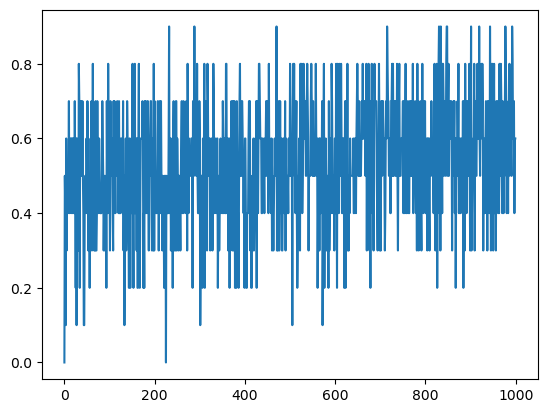

In [4]:
plt.plot(ar[-1])

In [18]:
theta[-1][g[-1]<0]

array([[5.12553378],
       [5.01335276],
       [5.01335276],
       ...,
       [5.04869631],
       [5.04869631],
       [5.04869631]])

In [5]:
print("Event realisation: ", theta[-1][g[-1]<0].shape)
print("unique values: ", np.unique(theta[-1][g[-1]<0], axis = 0).shape)

Event realisation:  (1427, 1)
unique values:  (573, 1)


In [9]:
from tqdm import tqdm

estimates = []

for _ in tqdm(range(10)):
    _, _, _, _, pf = subsim(pi, pi_marginal, g_lim, p0, N = N, spread = spread, g_failure='<=0')
    estimates.append(pf)

100%|██████████| 10/10 [06:45<00:00, 40.53s/it]


In [15]:
# Cv empirique

np.std(estimates) / 2.87e-7

0.3152742243900174

## Test for collision risk

In [1]:
from deep_traffic_generation.tcvae_pairs_disent import TCVAE_Pairs_disent
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDatasetPairsRandom
from traffic.core import Traffic

from subset_simulation import subsim, subsim_curve

import openturns as ot
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [2]:
dataset = TrafficDatasetPairsRandom.from_file(
    ("../deep_traffic_generation/data/training_datasets/to_LSZH_16_50_bb.pkl", "../deep_traffic_generation/data/training_datasets/ga_LSZH_14_50_bb.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    n_samples = 10000,
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

path = "../deep_traffic_generation/lightning_logs/tcvae_pairs_disent/version_22/"

t = PairsVAE(X = dataset, vae_type="TCVAEPairs_disent", sim_type = "generation")
t.load(path, dataset.parameters)
gen_vae = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler)

In [3]:
# Transform prior tscipy format

Z = t.latent_space(0)
p_z = t.VAE.lsr.get_prior()

#Create the multivariate distrib with 1d gmm on each dimension
marginals = []
for i in range(Z.shape[1]):
    collDist = [ot.Normal(mu.item(), sigma.item()) for mu, sigma in zip(p_z.base_dist.component_distribution.base_dist.loc.squeeze(2)[i], p_z.base_dist.component_distribution.base_dist.scale.squeeze(2)[i])]
    weights = p_z.base_dist.mixture_distribution.probs[i].detach().numpy()
    mixt = ot.Mixture(collDist, weights)
    marginals.append(mixt)
prior = ot.ComposedDistribution(marginals)

# isoproba transformation from N(0,1) to prior
isoTrans = prior.getInverseIsoProbabilisticTransformation()

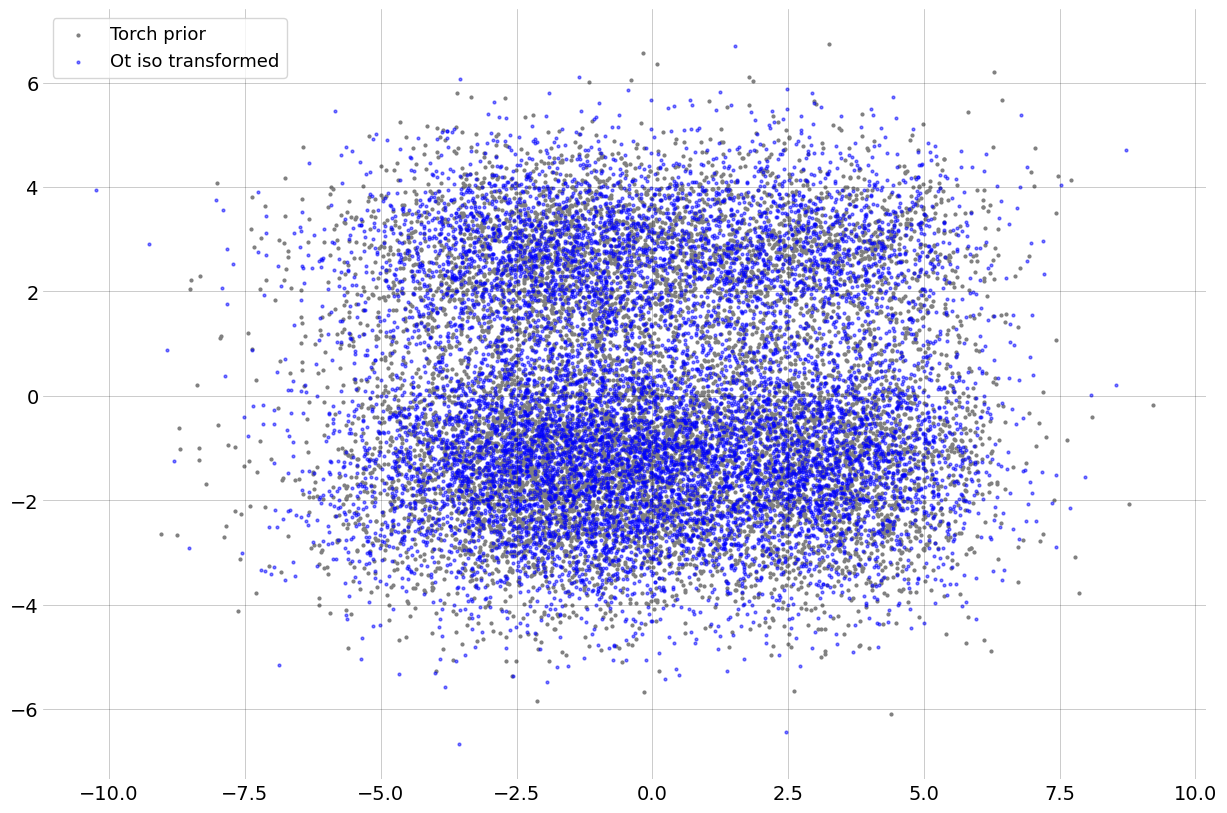

In [27]:
#Compare prior and iso transformed N(0,1)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal, norm

#Points from prior
n_gen = 10000
Z_torch = p_z.sample(torch.Size([n_gen])).squeeze(2)

#Points from N(0,1) transformed to prior
d = 10
pi = multivariate_normal(mean = np.zeros(d), cov = np.identity(d))
Z_ot = pi.rvs(n_gen)
Z_ot = isoTrans(ot.Sample(Z_ot))

#Only fitted on train data
pca = PCA(n_components=2).fit(Z_torch)
Z_emb_torch = pca.transform(Z_torch)
Z_gen_ot = pca.transform(Z_ot)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.scatter(Z_emb_torch[:, 0], Z_emb_torch[:, 1], s=4, c ='grey', label = "Torch prior")
    ax.scatter(Z_gen_ot[:, 0], Z_gen_ot[:, 1], s=4, c='blue', alpha = 0.5, label = "Ot iso transformed")

    ax.legend()

    plt.show()

In [4]:
def limit_state(z):
    """limit_state is the black box function for the sumbset samling. 

    inputs:
        - z = a latent space vector from N(0,1)
        
    outputs:
        - limit_state(X) = closest distance between the two trajectories of the pair
    """
    diam = 55
    
    #From N(0,1) to prior
    z = np.array(z).reshape(1,-1)
    z = isoTrans(ot.Sample(z))
    z = torch.Tensor(z)
    
    #Decode latent representation into a pair of trajectories
    decoded = t.decode(z)
    to = gen_vae.build_traffic(decoded[:,:200], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True).iterate_lazy().resample("1s").eval()
    to = to.assign(flight_id=lambda x: x.flight_id + "_to", inplace=True)
    ga = gen_vae.build_traffic(decoded[:,200:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True).iterate_lazy().resample("1s").eval() 
    ga = ga.assign(flight_id=lambda x: x.flight_id + "_ga", inplace=True)
    
    # Calulate distance between the two trajectories
    dist = to[0].distance(ga[0])
    dist["3d_distance"] = dist.apply(lambda x: ((x.lateral*1852)**2 + (x.vertical*0.3048)**2)**0.5 - diam, axis=1) #distance between two spheres in m
    return dist["3d_distance"].min()

In [28]:
d = 10
p0 = 0.2
N = 10000
spread = 0.01
pi = multivariate_normal(mean = np.zeros(d), cov = np.identity(d))
pi_marginal = d*[norm(loc = 0, scale = 1)]

theta, g, b, ar, pf = subsim(pi, pi_marginal, limit_state, p0, N = N, spread = spread, g_failure='<=0')
print("The probability of failure is : ", pf)
print("The intermediate thresholds are : ", b)

The probability of failure is :  0.00023769600000000005
The intermediate thresholds are :  [938.3068041307185, 399.9097193945687, 148.61602285176303, 46.014486229695976, 5.350601241201765]


Spread = 1, N = 1000 :
- 1st try: 0.00040200000000000007
- 2nd try: 0.0014100000000000004

Spread = 1, N=10000 : -> acceptance rate < 0.1
- 1st try:0.00027440000000000006
- 2nd try: 0.00034300000000000004

Spread = 0.1, N=10000 -> acceptance rate quite under 0.2
- 1st try : 0.0003101000000000001
- 2nd try : 0.0003892000000000001
- 3rd try : 0.00037990000000000007

Spread = 0.05, N=10000
- 1st try : 0.0003456000000000001

Spread = 0.01, N=10000
- 1st try : 0.0005600000000000002
- 2nd try : 0.00023580000000000007

Spread = 0.01, N = 10000, p0 = 0.2:
- 1st try : 0.00021881600000000007
- 2nd try : 0.00020348800000000007
- 3rd try : 0.00032288000000000005
- 4th try : 0.00023769600000000005

0.39080000000000004


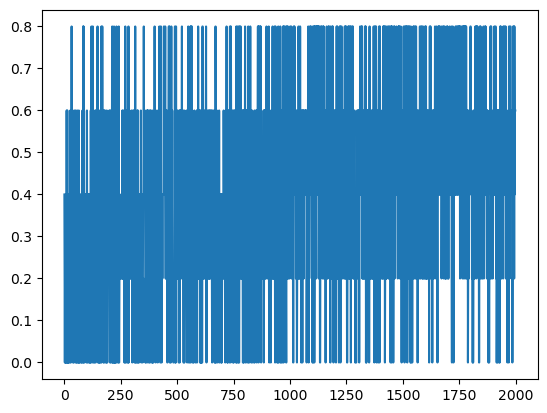

In [29]:
print(np.mean(ar[-1]))
plt.plot(ar[-1])

In [30]:
print("Event realisation: ", theta[-1][g[-1]<0].shape)
print("unique values: ", np.unique(theta[-1][g[-1]<0], axis = 0).shape)

Event realisation:  (7428, 10)
unique values:  (4528, 10)


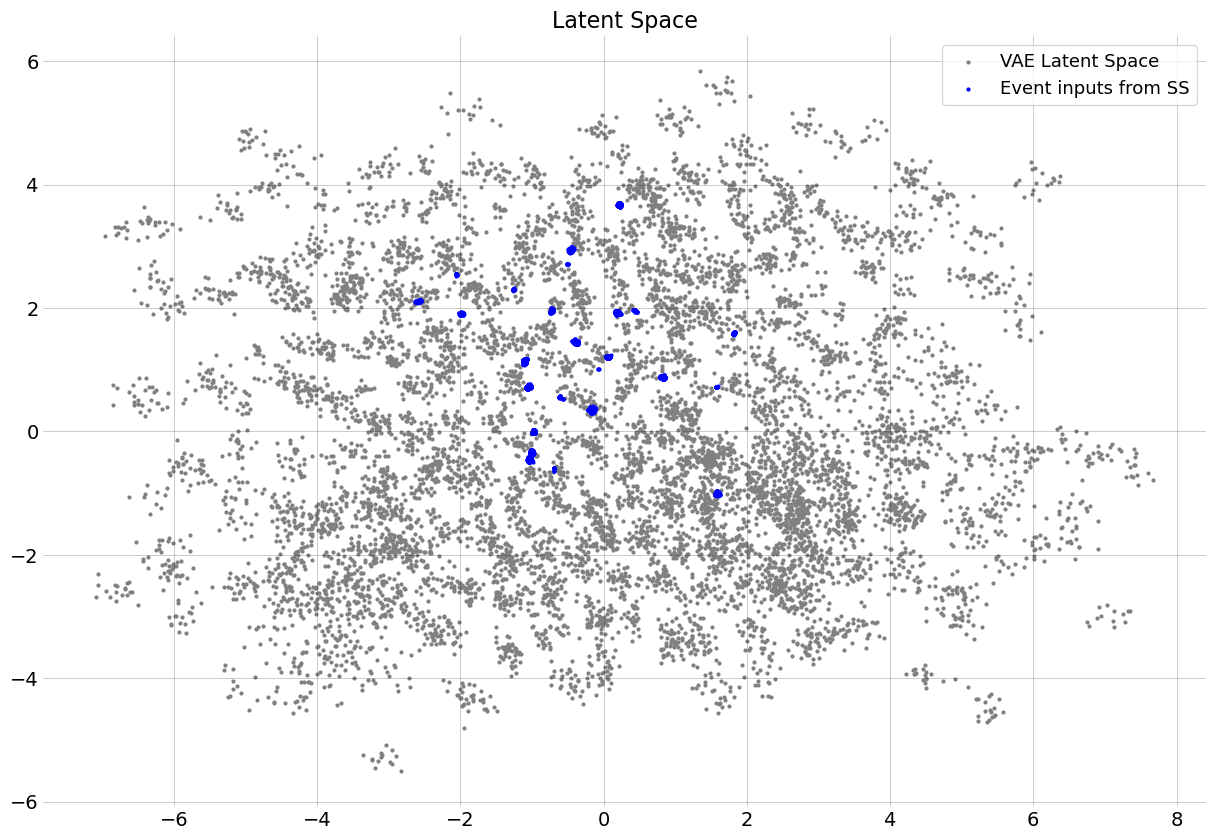

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Z = t.latent_space(0)

pca = PCA(n_components=2).fit(Z)
Z_emb = pca.transform(Z)
Z_gen_emb = pca.transform(theta[-1][g[-1]<0])

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.scatter(Z_emb[:, 0], Z_emb[:, 1], s=4, c ='grey', label = "VAE Latent Space")
    ax.scatter(Z_gen_emb[:, 0], Z_gen_emb[:, 1], s=4, c='blue', label = "Event inputs from SS")
    
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()
    
#Plus on réduit le Spread, plus les régios de défaillance dans l'espace latent sont localisées, mais aussi moins on a de duplicates

8944
Caluculted distance:  -2.034799084963062
SS distance output:  -2.034799084963062


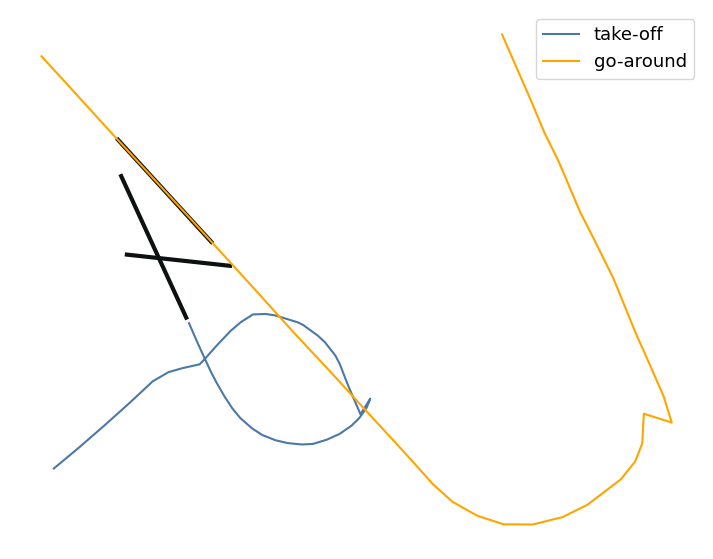

In [23]:
import torch
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(theta[-1]))
print(j)

#Reconstruction
z = isoTrans(ot.Point(theta[-1][j]))
decoded = t.decode(torch.Tensor(z).unsqueeze(0))
reconstructed_to = gen_vae.build_traffic(decoded[:,:200], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True).resample("1s").eval()
reconstructed_to = reconstructed_to.assign(flight_id=lambda x: x.flight_id + "_to", inplace=True)
reconstructed_ga = gen_vae.build_traffic(decoded[:,200:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True).resample("1s").eval()
reconstructed_ga = reconstructed_ga.assign(flight_id=lambda x: x.flight_id + "_ga", inplace=True)

dist = reconstructed_to[0].distance(reconstructed_ga[0])
# dist = reconstructed_ga[0].distance(reconstructed_to[0])
dist["3d_distance"] = dist.apply(lambda x: ((x.lateral*1852)**2 + (x.vertical*0.3048)**2)**0.5 - 55, axis=1)
print("Caluculted distance: ", dist["3d_distance"].min())
print("SS distance output: ", g[-1][j])

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    reconstructed_to.plot(ax, c="#4c78a8", label = "take-off")
    reconstructed_ga.plot(ax, c="orange", label = "go-around")
    plt.legend()

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

    plt.show()

Pour la suite: 

- Faire 100 runs (au moins 50) de SS et calculer le coefficient de variation empirique
- Comparer avec MC sur trajectoires observées et trajectoires générées
- Indices de Sobol sur la distance (voire Sobol sur les indicatirices)